# 2CSSID-TP06. Réseaux de neurones

Dans ce TP, nous allons voir les réseaux de neurones.
Premierement, nous allons implémenter la rétro-propagation, une fonction d'activation et une fonction du cout.
Ensuite, nous allons tester l'effet de l'initialisation des paramètres, les fonctions d'activation, ainsi que les fonctions d'optimisation.

Binômes : 
- **Binôme 1 :** MAHMAHI Anis
- **Binôme 2 :** BEKKAR Ilhem

In [1]:
import matplotlib
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
from matplotlib      import colors 
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.21.5', '1.4.2', '3.5.1')

In [2]:
from typing          import Tuple, List, Type, Union
from collections.abc import Callable

## I. Réalisation des algorithmes

Ici, nous définissons un API (une sorte d'interfaces) pour les fonctions d'activation et les fonctions du cout. 

In [3]:
# API
class Activation(object): 
    # Calculer l'activation en se basant sur Z (la somme linéaire)
    def activer(self, Z):
        pass
    # Calculer la dérivée en se basant sur Z et l'activation A
    def deriver(self, Z, H):
        pass

# API
class Cout(object): 
    # Calculer l'activation en se basant sur Z (la somme linéaire)
    def calculer(self, H, Y):
        pass
    # Calculer la dérivée en se basant sur Z et l'activation A
    def deriver(self, H, Y):
        pass


### I.1. Fonctions d'activation

L'activation logistique est calculée comme :
$$A = \sigma(Z) = \frac{1}{1+e^{-Z}}$$

La dérivée partielle est donnée par :
$$\frac{\partial \sigma(Z)}{\partial \theta} = \sigma(Z) (1-\sigma(Z))$$

In [4]:
# TODO: Dérivée de la fonction d'activation logistique
def d_sigmaf(Z, A): 
    return A*(1-A)

# Rien à programmer ici
def sigmaf(Z):
    return 1 / (1 + np.exp(-Z))
    
class Logistique(Activation):
    def activer(self, Z):
        return sigmaf(Z)
    def deriver(self, Z, H):
        return d_sigmaf(Z, H)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([0.84104179, 0.84290453]), array([0.1336905 , 0.13241648]))
#---------------------------------------------------------------------

logistique = Logistique()
z4_1       = np.array([1.666, 1.68])
a4_1       = logistique.activer(z4_1)
a4_1p      = logistique.deriver(z4_1, a4_1)

a4_1, a4_1p

(array([0.84104179, 0.84290453]), array([0.1336905 , 0.13241648]))

### I.2. Fonctions du coût

La fonction BCE est calaculée par :
$$BCE = - ( Y \log(H) + (1-Y) \log(1-H))$$

Sa dérivée est calculée par :
$$\frac{\partial BCE}{\partial \theta} = \frac{H-Y}{H - H^2}$$

In [5]:
# TODO: Dérivée de la fonction d'erreur BCE
def d_bcef(H, Y):
    return (H-Y)/(H-H*H)

def bcef(H, Y):
    return - (Y * np.log(H) + (1-Y) * np.log(1-H))

class BCE(Cout):
    def calculer(self, H, Y):
        return bcef(H, Y)
    def deriver(self, H, Y):
        return d_bcef(H, Y)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([1.83258146, 0.17078832]), array([ 6.25      , -1.18623962]))
#---------------------------------------------------------------------

bce = BCE()

H = np.array([0.840 , 0.843])
Y = np.array([0., 1.])
J = bce.calculer(H, Y)
DJ = bce.deriver(H, Y)

J, DJ

(array([1.83258146, 0.17078832]), array([ 6.25      , -1.18623962]))

### I.3. Neurone

$$\delta^{(l)} = \frac{\partial f^{(l)}}{\partial z^{(l)}} w^{(l+1)} \delta^{(l+1)}$$

$$\frac{\partial J}{\partial w^{(l)}} = a^{(l-1)} \delta^{(l)}$$

$$\frac{\partial J}{\partial b^{(l)}} = \delta^{(l)}$$

Le produit est un produit matriciel (sur $M$) et il faut prendre la moyenne des sorties (sur $Ln$). 

La fonction qui met à jour les paramètres prend en entrée : 
- $W[Lp]$ une liste des poids; un vecteur de taille $Lp$ (le nombre des neurones de la couche précédente)
- $b$ le biais 
- $Z[M]$ la combinaison linéaire du neurone courant; un vecteur de taille $M$ (le nombre des échantillons)
- $A[M]$ l'activation du neurone courant; un vecteur de taille $M$  
- $A\_past[M, Lp]$ les activations des neurones de la couche précédente; une matrice de taille est $(M * Lp)$
- $Delta\_next[M, Ln]$ le delta calculé dans la couche suivante; une matrice de taille $M * Ln$ ($Ln$ : le nombre des neurones dans la couche suivante)
- $W\_next[Ln]$ les poids vers la couche suivante; un vecteur de taille $Ln$
- $act$ c'est un object de type "Activation"; il fournit deux méthodes : "act.activer" et "act.deriver"
- $alpha$ le pas de l'entraînement 

In [6]:
# TODO: Rétro-propagation (neurone)
def neurone_maj(W, b, Z, A, A_past, Delta_next, W_next, act, alpha=1.):
    Delta =  act.deriver(0,A) * ( W_next @ Delta_next.T)
    bn    =  b - alpha*Delta.mean()  
    Wn    = W - alpha*(A_past.T@Delta)/len(W)
    
      
    return Wn,bn,Delta

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([0.49375218, 0.2046736 ]),
#  -0.0.30324311474187016,
#  array([ 0.00696306, -0.00047683]))
#---------------------------------------------------------------------


W_t = np.array([0.5, 0.2])
b_t = -0.3
Z_t = np.array([0.5, 2.2])
# M (l'activation actuelle)
A_t = np.array([0.62245933, 0.90024951])
# M * L (les activations de la couche précédente)
A_past_t = np.array([[2., -1.], [3., 5.]])
# L
Delta_next_t = np.array([[ 0.14523862, -0.02613822], [ 0.1394202, -0.02531591]]).T
W_next_t = np.array([0.3, -0.1])
act = Logistique() #la fonction d'activation

W_nouv, b_nouv, Delta_nouv = neurone_maj(W_t, b_t, Z_t, A_t, A_past_t, Delta_next_t, W_next_t, act, alpha=1.)

W_nouv, b_nouv, Delta_nouv

(array([0.49375218, 0.2046736 ]),
 -0.30324311474187016,
 array([ 0.00696306, -0.00047683]))

In [7]:
class Neurone(object):
    def __init__(self, taille_entree, activation=Logistique()):
        self.b   = 0.
        self.w   = np.array([0.] * taille_entree)
        self.act = activation
        
    def randomiser(self):
        self.w = np.random.rand(len(self.w))
        self.b = np.random.rand(1)[0]
        
    def __aggreger(self, X):
        return np.dot(X, self.w) + self.b
    
    def activer(self, X):
        self.a_past = X
        self.z      = self.__aggreger(X)
        self.a      = self.act.activer(self.z)
        return self.a
    
    def actualiser(self, delta_next, w_next, alpha=1.):
        w_ancien              = self.w.copy()
        self.w, self.b, delta = neurone_maj(self.w, self.b, self.z, self.a, self.a_past, 
                                            delta_next, w_next, self.act, alpha=alpha)
        return delta, w_ancien

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# z2_1 = [0.5 2.2]
# a2_1 = [0.62245933 0.90024951]
# derivee(a2_1) = [0.23500371 0.08980033]
# ancien b = -0.3
# ancien w = [0.5 0.2]
# delta2 = [ 0.00696306 -0.00047683]
# nouveaux b = -0.30324311473938026
# nouveaux w = [0.49375218 0.2046736 ]
#---------------------------------------------------------------------


# Céation d'un neurone avec deux entrées
n = Neurone(2)
# ---------------------
#On ne doit pas affecter les poids directement 
#Ici, c'est juste pour avoir les mêmes poids du neurone de sortie dans l'exemple du cours
# On va reproduire les paramètres du neurone 1 couche cachée 1 (couche 2)
n.b = -0.3
n.w = np.array([0.5, 0.2])
# ---------------------

# M X Lp (ici c'est X : couche d'entrée)
A1 = np.array([[2., -1.], [3., 5.]])
# M X Ln (Delta de la couche suivante)
Delta3 = np.array([[ 0.14523862, -0.02613822], [ 0.1394202, -0.02531591]]).T
W3_1 = np.array([0.3, -0.1])


A2_1 = n.activer(A1)
print("z2_1 = " + str(n.z))
print("a2_1 = " + str(A2_1))
# la dérivée de la fonction logistique n'a pas besoin de z, donc on passe 0
print("derivee(a2_1) = " + str(n.act.deriver(0,A2_1)))
print("ancien b = " + str(n.b))

Delta2, W2_ancien = n.actualiser(Delta3, W3_1) 

print("ancien w = " + str(W2_ancien))
print("delta2 = " + str(Delta2))
print("nouveaux b = " + str(n.b))
print("nouveaux w = " + str(n.w))

z2_1 = [0.5 2.2]
a2_1 = [0.62245933 0.90024951]
derivee(a2_1) = [0.23500371 0.08980033]
ancien b = -0.3
ancien w = [0.5 0.2]
delta2 = [ 0.00696306 -0.00047683]
nouveaux b = -0.30324311473938026
nouveaux w = [0.49375218 0.2046736 ]


### I.4. Couche

**Rien à programmer ici.**

Une classe qui définit une couche en indiquant le nombre des neurones (taille), le nombre de ces entrées et la fonction d'activation de ces neurones.
Cette classe comprend 3 méthodes : 
- randomiser : initialiser les paramètres des neurones d'une façon aléatoire
- propagation_avant : appliquer la propagatation avant 
- retro_propagation : appliquer la rétropropagation 

In [8]:
class Couche(object):
    
    def __init__(self, taille, taille_entree, activation=logistique):
        self.neurones = [Neurone(taille_entree, activation=activation) for i in range(taille)]
        
    def randomiser(self):
        for neurone in self.neurones:
            neurone.randomiser()

    def propagation_avant(self, X):
        activations = []
        for neurone in self.neurones:
            activations.append(neurone.activer(X))
        return np.array(activations).T
    
    def retro_propagation(self, delta_next, W_next, alpha=1.):
        W_anciens = []
        Deltas = []
        for i, neurone in enumerate(self.neurones):
            delta, w_ancien = neurone.actualiser(delta_next, W_next[i], alpha=alpha)
            W_anciens.append(w_ancien)
            Deltas.append(delta)
        return np.array(Deltas).T, np.array(W_anciens).T



#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# activations : [[0.62245933 0.66818777]
#  [0.90024951 0.96770454]]
# deltas : [[ 0.00696306  0.00682726]
#  [-0.00047683 -0.00017109]]
#---------------------------------------------------------------------

# la couche 2 
c2 = Couche(2, 2)

#On ne doit pas affecter les poids directement 
#Ici, c'est juste pour avoir les mêmes poids du neurone de sortie dans l'exemple du cours
c2.neurones[0].b = -0.3
c2.neurones[0].w = np.array([0.5, 0.2])
c2.neurones[1].b = 0.5
c2.neurones[1].w = np.array([0.3, 0.4])

a2 = np.array([[2., -1.], [3., 5.]])
# L
delta3 = np.array([[ 0.14523862, -0.02613822], [ 0.1394202, -0.02531591]]).T
w3 = np.array([[0.3, -0.1],[0.5, -0.3]])

# M X Lp (ici c'est X : couche d'entrée)
a1 = np.array([[2., -1.], [3., 5.]])
a2 = c2.propagation_avant(a1)
print("activations : " + str(a2))

Deltas2, W_anciens2 = c2.retro_propagation(delta3, w3)

print("deltas : " + str(Deltas2))

activations : [[0.62245933 0.66818777]
 [0.90024951 0.96770454]]
deltas : [[ 0.00696306  0.00682726]
 [-0.00047683 -0.00017109]]


### I.5. Réseau



In [9]:
class RN(object):
    def __init__(self, taille_entree, cout=bce, alpha=1.):
        self.taille_courante = taille_entree #la taille de la dernière couche
        self.cout = cout #objet de type Cout pour calculer le cout et sa dérivée
        self.alpha = alpha
        self.couches = []

    def ajouter_couche(self, taille, activation=logistique):
        nouv_couche = Couche(taille, self.taille_courante, activation=activation)
        self.couches.append(nouv_couche)
        self.taille_courante = taille
        
    def randomiser(self):
        for couche in self.couches:
            couche.randomiser()
    
    def predire(self, X): 
        Y = X
        if self.norm:
            Y = np.where(self.std==0, X, (X - self.mean)/self.std)
            
        for couche in self.couches:
            Y = couche.propagation_avant(Y)
        if Y.ndim == 2 and Y.shape[1] == 1:
            Y = Y.flatten()
        return np.where(Y < 0.5, 0, 1)
    
    
    def _faire_iteration(self, X, Y):
        # propagation avant
        a = X
        for couche in self.couches:
            a = couche.propagation_avant(a)
            
        # calcul du cout et sa dérivée 
        YY = np.array(Y)
        if YY.ndim < 2 : 
            YY = YY[:, np.newaxis]
        J = np.mean(self.cout.calculer(a, YY))
        J_prime = self.cout.deriver(a, YY)
        
        # retropropagation 
        w_past = np.array([[1.] * self.taille_courante])
        delta_past = J_prime
        for couche in reversed(self.couches): # on commance de la dernière couche vers la première
            delta_past, w_past = couche.retro_propagation(delta_past, w_past)
        return J
    
    def entrainer(self, X, Y, nbr_it=100, norm=False):
        couts = []
        X_norm = X
        self.norm = norm
        if norm:
            self.mean = np.mean(X, axis=0)
            self.std = np.std(X, axis=0)
            X_norm = np.where(self.std==0, X, (X - self.mean)/self.std)

        for i in range(nbr_it): 
            J = self._faire_iteration(X_norm, Y)
            couts.append(J)
        return couts
    
#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# le cout = 1.0020916974430965
# w4_1 = [0.51494626 0.56592079]
# w3_1 = [0.2665629 0.4641237]
# w3_2 = [-0.13199638 -0.33433028]
# w2_1 = [0.49375219 0.2046736 ]
# w2_2 = [0.29342937 0.40384135]
# la prédiction : [0 1]
#---------------------------------------------------------------------

X = np.array([[2., -1.], [3., 5.]])
Y = np.array([0., 1.])

rn = RN(2) #deux caractéristiques d'entrée
rn.ajouter_couche(2) #ajouter une couche avec 2 neurones (cachée)
rn.ajouter_couche(2) #ajouter une couche avec 2 neurones (cachée)
rn.ajouter_couche(1) #ajouter une couche avec 1 neurone (sortie)

#On ne doit pas affecter les poids directement 
#Ici, c'est juste pour avoir les mêmes poids du neurone de sortie dans l'exemple du cours
rn.couches[0].neurones[0].b = -0.3
rn.couches[0].neurones[0].w = np.array([0.5, 0.2])
rn.couches[0].neurones[1].b = 0.5
rn.couches[0].neurones[1].w = np.array([0.3, 0.4])

rn.couches[1].neurones[0].b = -0.3
rn.couches[1].neurones[0].w = np.array([0.3, 0.5])
rn.couches[1].neurones[1].b = -0.2
rn.couches[1].neurones[1].w = np.array([-0.1, -0.3])

rn.couches[2].neurones[0].b = 1.
rn.couches[2].neurones[0].w = np.array([0.7, 0.7])

J = rn._faire_iteration(X, Y)

print("le cout = " + str(J))
print("w4_1 = " + str(rn.couches[2].neurones[0].w))
print("w3_1 = " + str(rn.couches[1].neurones[0].w))
print("w3_2 = " + str(rn.couches[1].neurones[1].w))
print("w2_1 = " + str(rn.couches[0].neurones[0].w))
print("w2_2 = " + str(rn.couches[0].neurones[1].w))

rn.entrainer(X, Y, nbr_it=200)
print("la prédiction : " + str(rn.predire(X)))


le cout = 1.0020916974430962
w4_1 = [0.51494626 0.56592079]
w3_1 = [0.2665629 0.4641237]
w3_2 = [-0.13199638 -0.33433028]
w2_1 = [0.49375219 0.2046736 ]
w2_2 = [0.29342937 0.40384135]
la prédiction : [0 1]


## II. Application et analyse

In [10]:
# diabetes2
diabetes   = pd.read_csv("data/diabetes2.csv") 
X_diabetes = diabetes.iloc[:, :-1].values  
Y_diabetes = diabetes.iloc[:,  -1].values

# Cette configuration est mise en place comme ceci exprès
# C'est pour tester le cas où la régression est difavorisée
NBR_TEST   = 240
# Supposant que les 30% premières lignes sont pour le test et le reste pour l'entraînement
X_test     = X_diabetes[-NBR_TEST:, :] # 30% ou plus
Y_test     = Y_diabetes[-NBR_TEST:   ].reshape([-1, 1])

X_train    = X_diabetes[:-NBR_TEST, :] 
Y_train    = Y_diabetes[:-NBR_TEST   ].reshape([-1, 1])

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
from sklearn.preprocessing import StandardScaler

scaler   = StandardScaler()
X_trains = scaler.fit_transform(X_train)
X_tests  = scaler.transform(X_test)

X_trains[:5, :]

array([[ 0.63564802,  0.83833016,  0.16863427,  0.93506705, -0.67560188,
         0.22006711,  0.42947843,  1.43582544],
       [-0.85203884, -1.09137813, -0.14214721,  0.55085273, -0.67560188,
        -0.63225191, -0.38057337, -0.18535642],
       [ 1.23072277,  1.91039032, -0.24574104, -1.30618316, -0.67560188,
        -1.03405944,  0.56155209, -0.10003106],
       [-0.85203884, -0.96885697, -0.14214721,  0.16663841,  0.12145706,
        -0.44961212, -0.92060791, -1.03861003],
       [-1.14957621,  0.50139697, -1.48886696,  0.93506705,  0.74892899,
         1.37678577,  5.30446409, -0.0147057 ]])

#### II.1. Paramètres initiaux et complexité

Nous voulons tester l'intêt de l'initialisation des paramètres (thétas) et la complexité du modèle.
Pour ce faire, cinq modèles ont été entrainés afin de récupérer l'erreur d'entrainement et de la validation. 
Les modèles testé sont :
- **Log0** : Un seul neurone (régression logistique) avec initialisation 0
- **LogR** : Un seul neurone (régression logistique) avec initialisation aléatoire
- **RN0** : Un réseau de neurones 4(relu)X2(relu)X1(sigmoid) avec initialisation 0
- **RN1** : Un réseau de neurones 4(relu)X2(relu)X1(sigmoid) avec initialisation 1
- **RNR** : Un réseau de neurones 4(relu)X2(relu)X1(sigmoid) avec initialisation aléatoire

Log0 : Entrainement ...
LogR : Entrainement ...
RN0 : Entrainement ...
RN1 : Entrainement ...
RNR : Entrainement ...


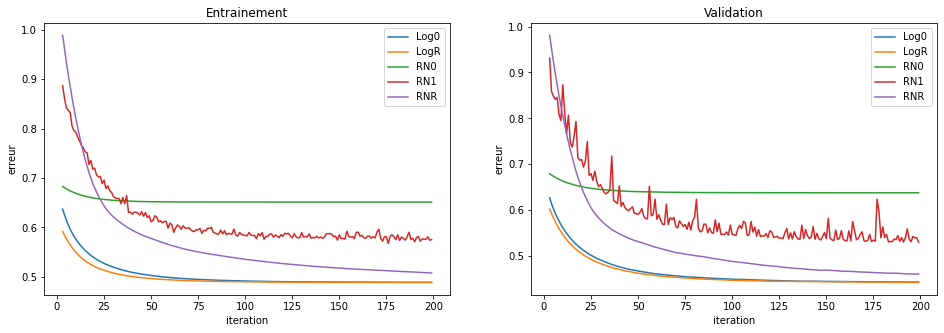

In [12]:
import logging, os
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow              import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, Model

alpha  = 0.01
NBR_IT = 200

M, N = X_train.shape

# ==================================
# Définition des modèles
# ==================================

modeles = {}

modeles['Log0'] = Sequential()
modeles['Log0'].add(Dense(1, activation="sigmoid", kernel_initializer='zero', bias_initializer='zeros'))

modeles['LogR'] = Sequential()
modeles['LogR'].add(Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))

modeles['RN0']  = Sequential()
modeles['RN0'].add(Dense(4, activation="relu", kernel_initializer='zero', bias_initializer='zeros'))
modeles['RN0'].add(Dense(2, activation="relu", kernel_initializer='zero', bias_initializer='zeros'))
modeles['RN0'].add(Dense(1, activation="sigmoid", kernel_initializer='zero', bias_initializer='zeros'))

modeles['RN1']  = Sequential()
modeles['RN1'].add(Dense(4, activation="relu", kernel_initializer='one', bias_initializer='one'))
modeles['RN1'].add(Dense(2, activation="relu", kernel_initializer='one', bias_initializer='one'))
modeles['RN1'].add(Dense(1, activation="sigmoid", kernel_initializer='one', bias_initializer='one'))

modeles['RNR']  = Sequential()
modeles['RNR'].add(Dense(4, activation="relu", kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
modeles['RNR'].add(Dense(2, activation="relu", kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
modeles['RNR'].add(Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))

# ==================================
# Entrainement des modèles
# ==================================

# on n'affiche pas les 3 premières itérations, le temps que le modèle se stabilise
# sinon, un modèle peut avoir une grande valeur par rapport aux autres 
# donc, on ne peut pas visualiser la convergence des autres
IT_range = range(NBR_IT)[3:]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))


for nom, modele in modeles.items():
    modele.compile(loss      = tf.keras.losses.binary_crossentropy,
                 optimizer = tf.keras.optimizers.SGD(learning_rate=alpha))
    print(nom, ': Entrainement ...')
    results = modele.fit(X_trains, Y_train, epochs=NBR_IT, validation_data=(X_tests, Y_test), verbose=0)
    
    # ===========================
    # PREPARATION DE L'AFFICHAGE
    # ===========================
    ax1.plot(IT_range, results.history["loss"    ][3:], label=nom)
    ax2.plot(IT_range, results.history["val_loss"][3:], label=nom)

# ==================================
# Affichage 
# ==================================

ax1.title.set_text("Entrainement")
ax2.title.set_text("Validation")

ax1.set(xlabel='iteration', ylabel='erreur')
ax2.set(xlabel='iteration', ylabel='erreur')

ax1.legend()
ax2.legend()
plt.show()

**TODO: Analyser les résultats**
- Nous remarquons que les modèles avec un seul neurone sont plus rapides que les modèles de réseau de neurones (en terme des itérations et en terme de temps). Pourquoi ?
- Nous remarquons que **RN0** ne s'améliore pas (il stagne dès les premières itérations). Expliquer pourquoi.
- Nous remarquons que **RN1** s'améliore par rapport à **RN0**, mais il stagne rapidement par rapport **RNR**. Expliquer pourquoi.
- En se basant sur la validation, quelle est le rapport entre le nombre des couches, la complexité du problème, le nombre/qualité des données et les problèmes d'apprentissage (sous/sur). Mentionner toutes les combinaisons qui peuvent causer des problèmes.

**Réponse**
- les modèles avec un seul neurone sont plus rapides parce que c'est moins de calcule (moins de poids a calculer). 
- Lorsque les poids sont mis à zéro, les valeurs des gradients seront les mêmes pour chaque poid dans les couches cachées, donc tous les poids ont la même valeur dans les itérations suivantes, ce qui se traduit par la non-amélioration de l'erreur pour toutes les n itérations.
 
- **RN1** ne s'améliore pas par rapport au **RN0** car lorsque les neurones ont les mêmes poids initiaux, ils vont apprendre de la même façon ==> redondance. Contrairement au **RNR** oú on essaye de résoudre le probleme de redondance, en-empêchant les neurones d'apprendre les mêmes caractéristiques. Le but est de faire apprendre chaque neurone différemment, et cette technique donne une meilleure performance que l'initialisation a zéro.
- - problème simple + plus de couche = sur-apprentissage 
  - problème complexe + moins de couche  = sous-apprentissage
  - Dans tous les cas si la qualité des données est mavaise et si le nbr de données est petit alors on aura toujours une mauvaise généralisation.




#### II.2. Fonctions d'activation

Nous voulons tester quelles sont les fonctions d'activation plus adéquates aux couches cachées et celles à la couche de sortie.
Pour ce faire, cinq modèles ont été entrainés afin de récupérer l'historique de l'erreur d'entrainement. 
Les modèles testé sont :
- **relu->sigm** : un réseau avec **relu** dans les couches cachées et **sigmoid** dans la couche de sortie
- **sigm->sigm** : un réseau avec **sigmoid** dans les couches cachées et **sigmoid** dans la couche de sortie
- **tanh->sigm** : un réseau avec **tanh** dans les couches cachées et **sigmoid** dans la couche de sortie
- **sigm->relu** : un réseau avec **sigmoid** dans les couches cachées et **relu** dans la couche de sortie
- **relu->relu** : un réseau avec **relu** dans les couches cachées et **relu** dans la couche de sortie

relu->sigm : Entrainement ...
sigm->sigm : Entrainement ...
tanh->sigm : Entrainement ...
sigm->relu : Entrainement ...
relu->relu : Entrainement ...


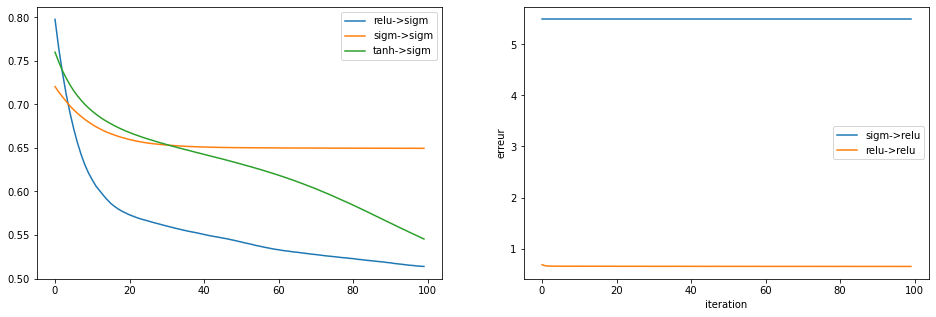

In [13]:
alpha  = 0.01
NBR_IT = 100

M, N = X_train.shape

L1 = 2 # Nombre des neurones dans la couche 1
L2 = 2 # Nombre des neurones dans la couche 2

# ==================================
# Définition des modèles
# ==================================

defs = [ # Les définitions
    ('relu->sigm', 'relu', 'sigmoid'),
    ('sigm->sigm', 'sigmoid', 'sigmoid'),
    ('tanh->sigm', 'tanh', 'sigmoid'),
    ('sigm->relu', 'sigmoid', 'relu'),
    ('relu->relu', 'relu', 'relu')
]

modeles = {}
params = {'kernel_initializer':'glorot_uniform', 'bias_initializer':'glorot_uniform'}

for nom, in_act, out_act in defs:
    modeles[nom] = Sequential()
    modeles[nom].add(Dense(L1, activation = in_act , **params))
    modeles[nom].add(Dense(L2, activation = in_act , **params))
    modeles[nom].add(Dense(1,  activation = out_act, **params))

# ==================================
# Entrainement des modèles
# ==================================

results = {}

for nom, modele in modeles.items():
    modele.compile(loss      = tf.keras.losses.binary_crossentropy,
                 optimizer = tf.keras.optimizers.SGD(learning_rate=alpha))
    print(nom, ': Entrainement ...')
    results[nom] = modele.fit(X_trains, Y_train, epochs=NBR_IT, verbose=0)
    

# ==================================
# Affichage 
# ==================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

for nom, result in results.items():
    ax = ax1 if nom.endswith('sigm') else ax2
    ax.plot(range(NBR_IT), result.history['loss'], label=nom)
    
ax1.legend()
ax2.legend()
plt.xlabel("iteration")
plt.ylabel("erreur")
plt.legend()
plt.show()

**TODO: Analyser les résultats**
- Nous remarquons que le modèle **sigmoid->sigmoid** a stagné rapidement. Expliquer comment ?
- Nous remarquons que ce modèle a convergé plus rapidement (en terme de nombre des itérations) par rapport aux deux modèles avec sortie **sigmoid**. Pourquoi ?
- Nous remarquons que les modèles avec sortie **relu** ne sont pas stables ; à chaque exécution, nous aurons un diagramme différent (des fois amélioration, des fois détérioration, etc.). Il faut noter que l'initialisation aléatoire n'est pas la source du problème vu qu'il y a d'autres modèles similaires mais stables. Donc, pourquoi nous avons eu ce comportement ?

**Réponse**
- En utilisant sigmoid comme fonction d'activation dans les couches cachées, on risque de rencontrer le probleme de Vanishing Gradient parce que la dérivé du sigmoid est définie sur [0 , 0.25] donc durant la mise a jour des W, la multiplications des dérivés sera de plus en plus petite (trés proche de 0) donc les W ne vont pas changer avec le temps.   
- La meme réponse que la question précédente + les dérivées des Relu et tanh diminue le problème de disparition des gradients et donne une plage de valeurs plus vague que la dérivée de sigmoid ((0 ou 1) et [0 , 1] respectivement ) donc ca va augmenter la quantité recu pour mettre a jour les poids et donc ca garanter une continuation d'apprentissage plus long.
- Comme le probleme traité ici est un probleme de classification (0 ou 1) donc mettre ReLU comme fonction de sortie n'a aucun sense car elle a une plage de 0, +infini et il est difficile de s'ajuster sur une plage plus restreinte

#### II.3. Fonctions d'optimisation

Nous voulons tester des différentes fonctions d'optimisation.
Pour ce faire, quatres modèles ont été entrainés afin de récupérer l'historique de l'erreur d'entrainement. 
Les modèles testés sont :
- **GD** : un réseau entrainé avec la descente des gradients
- **Adagrad** : un réseau entrainé avec AdaGrad
- **RMSprop** : un réseau entrainé avec RMSprop
- **Adam** : un réseau entrainé avec Adam

GD : entrainement ...
Adagrad : entrainement ...
RMSprop : entrainement ...
Adam : entrainement ...


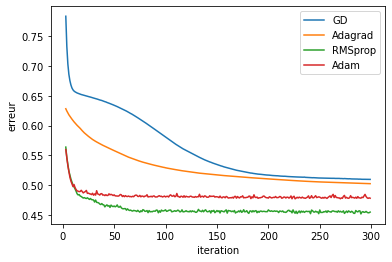

In [15]:
alpha  = 0.01
NBR_IT = 300

M, N = X_train.shape

L1 = 2
L2 = 2

# on n'affiche pas les 3 premières itérations, le temps que le modèle se stabilise
# sinon, un modèle peut avoir une grande valeur par rapport aux autres 
# donc, on ne peut pas visualiser la convergence des autres
IT_range = range(NBR_IT)[3:]

defs = [ # Les définitions
    ('GD'     , tf.keras.optimizers.SGD    (learning_rate=alpha)),
    ('Adagrad', tf.keras.optimizers.Adagrad(learning_rate=alpha)),
    ('RMSprop', tf.keras.optimizers.RMSprop(learning_rate=alpha)),
    ('Adam'   , tf.keras.optimizers.Adam   (learning_rate=alpha))
]

params = {'kernel_initializer':'glorot_uniform', 'bias_initializer':'glorot_uniform'}

for nom, opt in defs:
    modele = Sequential()
    modele.add(Dense(L1, activation="relu"   , **params))
    modele.add(Dense(L2, activation="relu"   , **params))
    modele.add(Dense(1,  activation="sigmoid", **params))
    modele.compile(loss      = tf.keras.losses.binary_crossentropy,
                   optimizer = opt)
    
    print(nom, ': entrainement ...')
    results = modele.fit(X_trains, Y_train, epochs=NBR_IT, verbose=0)
    plt.plot(IT_range, results.history["loss"][3:], label=nom)


plt.xlabel("iteration")
plt.ylabel("erreur")
plt.legend()
plt.show()

**Analyser les résultats**
- Nous remarquons que le modèle **GD** converge plus vite que **AdaGrad**. Pourquoi ?
- Pourquoi **RMSprop** converge plus rapidement que **AdaGrad**, pourtant leurs equations sont presque similaire ? (ici, vous devez expliquer l'apport dans l'equation du premier par rapport au deuxième)
- En exécutant ce code plusieurs fois, nous remarquons que Adam est plus stable. Pourquoi ?

**Réponse**
- A cause de la décroissance monotone des taux d'apprentissage, à un certain moment, le modèle **AdaGrad** arrete d'apprendre car le taux d'apprentissage est presque proche de 0 donc les W arretent de se changer.
- Le probleme de **AdaGrad** c'est la division sur le **v** qui devient trop grand avec le temps (le v c'est la somme des gradients), donc on introduit **RMSprop**  qui vient de changer l'expression de **v** par introduire la variable **B** ( l'ajout du terme **Bv** et multiplication la somme des gradients précedents par **1-B**), B appartient [0 , 1], on prend par exemple B=0.9 alors avec le temps et lorsque la somme des gradients devient trop grand 1-B = 0.1 alors ca va diminuer l'effet de ce terme et donc on va prévenir l'explosion de denominateur (le taux d'apprentissage continue de se changer) et on regle par la suite le probleme de stop learning (**B** donne plus de poid au dernier **v** que la somme des gradients ). 
- Adam est plus stable car il fait tout ce que RMSProp fait pour résoudre le problème d'explosion du dénominateur de AdaGrad (moment du 2em ordre). En plus de cela, utiliser un moment du premier ordre m et le rapport entre ces deux moments va ajuster au mieux les pas a prendre pour calculer les prochaines W .